<i>DISCLAIMER:<br>
Bellow code is only for informative purpose, i renounce any responsibility regarding this code and bellow trained model causing loss of money during trading on real market.</i>

# Stock price prediction : NVDA

This page does following:

- Libraries and trained model from previous step are loaded

- Defined customized functions as well as loss function

- Data are pulled, indicators are applied and prediction is made

<b>Import libraries and customized loss function and define customized function</b>

Bellow code defines customized function that are processing loaded data from stock market and makes prediction. Dataframe is normalized and reverted back via following formulas

<i>Linear scaling formula: x ′ = ( x − x m i n ) / ( x m a x − x m i n )</i><br>
<i>Reverse linear scaling: x = (x * (maxv-minv)) + minv</i>

In [1]:
#Libraries
import tensorflow as tf
import yfinance as yf
import talib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

#Customized loss function
def sign_penalty(y_true,y_pred):
    penalty = 100.
    loss = tf.where(tf.less(y_true*y_pred,0),
                    penalty * tf.square(y_true-y_pred),
                    tf.square(y_true - y_pred)
                   )
    
    return(tf.reduce_mean(loss,axis=-1))

tf.keras.losses.sign_penalty = sign_penalty

#Customized functions
def norm_df(pred1):
    df_temp = pd.DataFrame()
    try:
        pred1 = pred1.drop('Date',axis=1)
    except:
        pass
    pred_np = pred1.to_numpy()
    maxv = np.max(pred_np)
    minv = np.min(pred_np)
    df_temp = (pred1.iloc[:,:]-minv)/(maxv-minv)
    
    return df_temp, maxv,minv
def revert_df(df,maxv,minv):
    df_temp = pd.DataFrame() 
    df_temp = (df.iloc[:,:]*(maxv-minv))+minv
    
    return df_temp
def revert_prediction(value,maxv,minv):
    
    return (value * (maxv-minv))+minv

def MakePred(series,model):
    pr = series.to_numpy()
    series2=np.array([[pr]])   
    pred = tf.data.Dataset.from_tensor_slices(series2)
    prediction = model.predict(pred)
        
    return prediction
    
def Predict(pred):
    df_temp1, maxv, minv = norm_df(pred)
    pr = MakePred(df_temp1,model)
    prediction = revert_prediction(pr,maxv,minv)
    prediction = np.squeeze(prediction)
    
    #print("Prediction is: ",prediction)
    return prediction

def Profit_calculation(budget, entry, prediction):
    qty = round(budget / entry,0)
    return (prediction - entry) * qty 


<b>Load trained model</b>

In [2]:
model = tf.keras.models.load_model('nvda_80_model_checkpoint.h5', custom_objects={'sign_penalty': sign_penalty} )
model

<b>Load data from stock market</b>

Bellow code will load last 2 months of data via yahoo finance. Exponential moving averages are placed and formations are being selected. If condition is passed, we can run prediction, <b>if condition is not met, we should not trade today.</b>

<b>Traded Formation</b><br>
Condition 0: Last candle lower is higher than EMA6<br>
Condition 1: Last EMA6 is lower than EMA12<br>

In [13]:
stock = yf.download('nvda', 
                      start='2021-01-27', 
                      end='2022-06-11', 
                      interval="1wk",
                      progress=False,
)
stock = stock.dropna(axis=0)
#Set Indicators
stock['EMA6'] = talib.EMA(stock['Close'], timeperiod=6)
stock['EMA12'] = talib.EMA(stock['Close'], timeperiod=12)
stock['EMA24'] = talib.EMA(stock['Close'], timeperiod=24)
stock = stock.drop(labels=['Adj Close','Volume'],axis=1)

#Reset index
stock = stock.reset_index()

#Get final dataframe
trading_formation = stock.iloc[len(stock)-6:-1]

print("Last Close: ",trading_formation.iloc[4,4])
print("Last Open: ",trading_formation.iloc[4,1])
print("Last High: ",trading_formation.iloc[4,2])
print("First open: ",trading_formation.iloc[0,1])
print("Last EMA6: ",trading_formation.iloc[4,5])
print("Last EMA12: ",trading_formation.iloc[4,6])

#Check condition
#Trading Condition
if (#Last close is lower than EMA6
    (trading_formation.iloc[4,4] < trading_formation.iloc[4,5]) 
    #Last EMA6 is lower than EMA12        
    and (trading_formation.iloc[4,5] < trading_formation.iloc[4,6])):

                     
    entry = trading_formation.iloc[4,2]
    print("\nTrading condition passed, you can make prediction")
    print("\nEntry price: ",round(entry,4))
else:
    print("condition NOT passed, do NOT trade")


Last Close:  169.74000549316406
Last Open:  191.38999938964844
Last High:  193.3699951171875
First open:  180.33999633789062
Last EMA6:  183.1159824966712
Last EMA12:  197.40110882139098

Trading condition passed, you can make prediction

Entry price:  193.37


<ipython-input-13-4640eafb96fc>:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  stock['EMA6'] = talib.EMA(stock['Close'], timeperiod=6)
<ipython-input-13-4640eafb96fc>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  stock['EMA12'] = talib.EMA(stock['Close'], timeperiod=12)
<ipython-input-13-4640eafb96fc>:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pand

<b>Make Prediction</b>

In [14]:
#trading_formation
trading_formation = stock.iloc[len(stock)-6:-1]
trading_formation

,Date,Open,High,Low,Close,EMA6,EMA12,EMA24
67,2022-05-09,180.339996,182.550003,155.669998,177.059998,198.269329,215.827986,229.070944
68,2022-05-16,175.089996,183.710007,157.550003,166.940002,189.318093,208.306758,224.100469
69,2022-05-23,162.740005,188.809998,157.800003,188.110001,188.972924,205.199565,221.221231
70,2022-05-30,189.800003,196.190002,181.220001,187.199997,188.466373,202.430400,218.499533
71,2022-06-06,191.389999,193.369995,168.690002,169.740005,183.115982,197.401109,214.598771


In [15]:
budget = 10000

penalisation = 0
acceptance = 1

pred = Predict(trading_formation)
profit_raw = Profit_calculation(budget, entry, pred)

ppred = round(pred-penalisation,5)
profit_pen = Profit_calculation(budget, entry, ppred)
    
if np.max([pred,ppred])-entry > 0:
    print("Entry price is: ",round(entry,4))
    print("\nRaw prediction is: ",np.round(pred,4))
    print("Raw profit is: ",round(profit_raw,4))
    print("\nPenalised prediction is: ",round(ppred,4))
    print("Penalised Profit is: ",round(profit_pen,4))

else:
    print("Prediction is NOT profitable")
    print("\npredictions: ",pred,ppred)
    print("\nEntry price: ",round(entry,4))
    print("Max Prediction: ",round(np.max([pred,ppred]),4))

Entry price is:  193.37

Raw prediction is:  200.9725
Raw profit is:  395.332

Penalised prediction is:  200.9725
Penalised Profit is:  395.3318


<b>Plot chart</b>

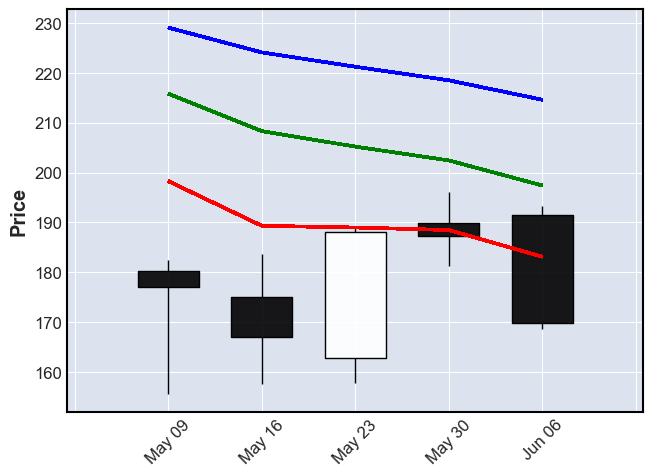

In [16]:
import mplfinance as mpf

selected_df = trading_formation.reset_index()
#print(selected_df)

#Get EMAs
dates = selected_df['Date']

#Get EMAs
dates = selected_df['Date']
ema6 = selected_df['EMA6']
ema12 = selected_df['EMA12']
ema24 = selected_df['EMA24']

datepairs_ema6 = [(d1,d2) for d1,d2 in zip(dates,ema6)]
datepairs_ema12 = [(d1,d2) for d1,d2 in zip(dates,ema12)]
datepairs_ema24 = [(d1,d2) for d1,d2 in zip(dates,ema24)]

#Format Dataframe
quotes = selected_df.iloc[:,:10]
quotes['Date'] = quotes['Date'].astype('datetime64')
quotes = quotes.set_index('Date')

try: 
    quotes = quotes.drop('index',axis=1)
except:
    pass
  
#Plot
quotes = quotes.iloc[:,:8]
quotes
quotes.columns=['open','high','low','close','ema6','ema12','ema24']
quotes
#Plot Chart
mpf.plot(quotes,type='candle',alines=dict(alines=[datepairs_ema6,datepairs_ema12,datepairs_ema24],colors=['r','g','b']))